# admirals - stlr features
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Feb 25, 2022

## Hypothesis
The goal of this notebook is to compare the results of the model with the model using standard StellarAlgo features with the engineered retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189'  
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 16 # admirals
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrAHL].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(11070, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11070 entries, 0 to 11069
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            11070 non-null  int64  
 1   dimCustomerMasterId     11070 non-null  int64  
 2   customerNumber          11070 non-null  object 
 3   year                    11070 non-null  int64  
 4   productGrouping         11070 non-null  object 
 5   totalSpent              11070 non-null  float64
 6   recentDate              11070 non-null  object 
 7   attendancePercent       11070 non-null  float64
 8   renewedBeforeDays       11070 non-null  int64  
 9   isBuyer                 11070 non-null  object 
 10  source_tenure           11070 non-null  int64  
 11  tenure                  11070 non-null  int64  
 12  distToVenue             11070 non-null  float64
 13  totalGames              11070 non-null  int64  
 14  recency                 11070 non-null

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
                "attendancePercent",
                "distToVenue",
                "inperson_contact",
                "inbound_phonecall",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "outbound_phonecall",
                "phonecall",
                "recency",
                "source_tenure",
                "renewedBeforeDays",
                "isNextYear_Buyer",
                "productGrouping",
                "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (8034, 17)
Unseen Data For Predictions: (1418, 17)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "attendancePercent",
                "distToVenue",
                "inperson_contact",
                "inbound_phonecall",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "outbound_phonecall",
                "phonecall",
                "recency",
                "source_tenure",
                "renewedBeforeDays"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7225,0.8008,0.6389,0.6842,0.6605,0.4263,0.4273,0.3860
lr,Logistic Regression,0.7113,0.7602,0.5564,0.6996,0.6192,0.3917,0.3988,0.3090


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6852,0.7917,0.5972,0.6347,0.6154,0.3494,0.3498
1,0.7379,0.8233,0.6354,0.7121,0.6716,0.4547,0.4567
2,0.7101,0.7861,0.6667,0.6531,0.6598,0.4073,0.4074
3,0.7394,0.8049,0.6458,0.7099,0.6764,0.4590,0.4605
4,0.7262,0.8027,0.6562,0.6823,0.6690,0.4357,0.4360
5,0.6735,0.7545,0.5986,0.6179,0.6081,0.3284,0.3285
6,0.7291,0.7963,0.6228,0.7031,0.6606,0.4366,0.4388
7,0.7218,0.8018,0.6332,0.6854,0.6583,0.4243,0.4253
8,0.7522,0.8229,0.6771,0.7196,0.6977,0.4881,0.4887
9,0.7493,0.8237,0.6562,0.7241,0.6885,0.4796,0.4812


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(1618, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
9452,16,1376729,2180281,2021,Full Season,323.89,2022-02-05,0.875000,624,TRUE,...,0,0,0.0,1,53,0,0,0,0.7434,0.2566
9453,16,1376755,1706812,2021,Flex Plan,290.25,2021-10-16,1.000000,3,TRUE,...,0,0,0.0,1,53,0,0,0,0.7914,0.2086
9454,16,1376916,2334235,2021,Flex Plan,176.40,2022-02-26,3.000000,56,TRUE,...,0,0,0.0,1,53,0,0,1,0.4754,0.5246
9455,16,1376922,1190934,2021,Flex Plan,226.80,2022-01-28,1.000000,58,TRUE,...,0,0,0.0,1,53,0,0,0,0.9960,0.0040
9456,16,1377224,1111087,2021,Half Season,487.35,2022-01-08,0.714286,26,TRUE,...,0,0,0.0,1,53,0,0,1,0.4894,0.5106


In [11]:
new_predictions["Label"].value_counts()

0    1253
1     365
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    889
(0.2, 0.4]       269
(0.4, 0.6]       186
(0.6, 0.8]       162
(0.8, 1.0]       112
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

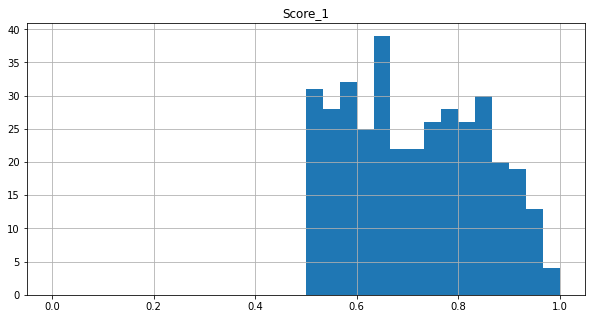

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

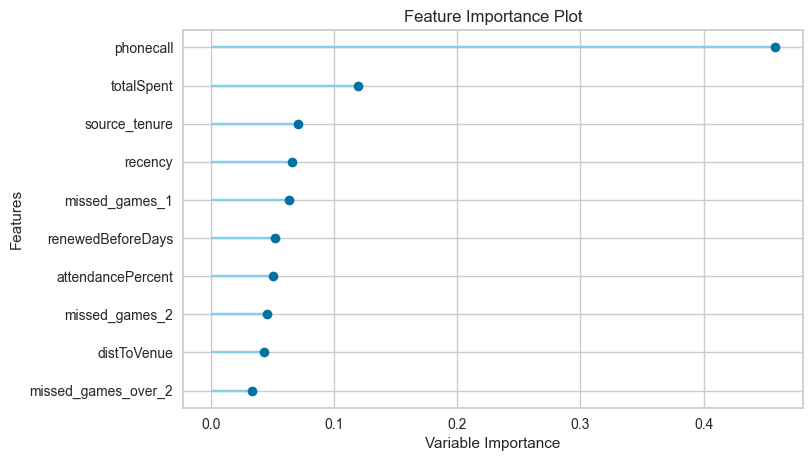

In [14]:
plot_model(best_model, plot='feature')

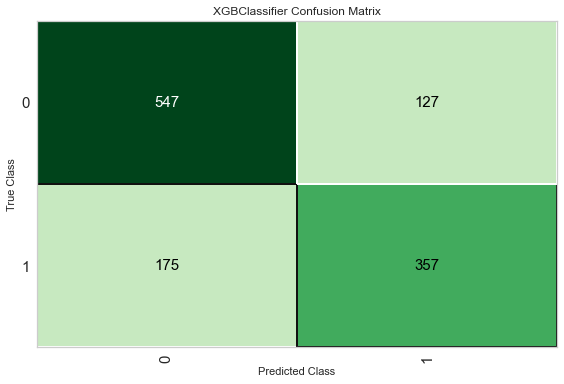

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?